In [1]:
import sys
from pathlib import Path
from typing import Any, Callable, Dict, Tuple

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader

data_dir = Path("measurements")
print(f"Data resides in: {data_dir.resolve()}")

Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_paper/tfim_ent_16/measurements


In [2]:
class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim

        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))

    def forward(self, cond: torch.Tensor):
        if cond.dim() == 1:
            cond = cond.view(-1, self.cond_dim)

        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)

        N, H = self.num_visible, self.num_hidden
        gamma_b, beta_b, gamma_c, beta_c = torch.split(x, [N, N, H, H], dim=-1)
        return gamma_b, beta_b, gamma_c, beta_c


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, k: int = 1, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        self.initialize_weights(w_std=0.01)

        self.conditioner = Conditioner(num_visible=num_visible, num_hidden=num_hidden,
                                       cond_dim=cond_dim, hidden_width=conditioner_width)

    def initialize_weights(self, w_mean: float = 0.0, w_std: float = 0.01, bias_val: float = 0.0):
        nn.init.normal_(self.W, mean=w_mean, std=w_std)
        nn.init.constant_(self.b, bias_val)
        nn.init.constant_(self.c, bias_val)

    @staticmethod
    def _free_energy(v: torch.Tensor, W: torch.Tensor, b: torch.Tensor, c: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=W.dtype, device=W.device)
        term1 = -(v * b).sum(dim=-1)
        term2 = F.softplus(v @ W + c).sum(dim=-1)
        return term1 - term2

    def _compute_effective_biases(self, cond: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b # unsqueeze for broadcasting
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    def _gibbs_step(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor, T: float, rng: torch.Generator):
        p_h = torch.sigmoid((v @ self.W + c_mod) / T)
        h = torch.bernoulli(p_h, generator=rng)
        p_v = torch.sigmoid((h @ self.W.t() + b_mod) / T)
        v_next = torch.bernoulli(p_v, generator=rng)
        return v_next

    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        fe = self._free_energy(v, self.W, b_mod, c_mod)
        return -0.5 * fe / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        values, _, cond = batch
        v_data = values.to(dtype=self.W.dtype, device=self.W.device)
        cond = cond.to(v_data.device, dtype=v_data.dtype)

        rng = aux_vars.get("rng", torch.Generator(device="cpu"))
        l2_strength = float(aux_vars.get("l2_strength", 0.0))
        noise_frac = float(aux_vars.get("noise_frac", 0.05))

        b_mod, c_mod = self._compute_effective_biases(cond)
        l2_reg = (self.b.unsqueeze(0) - b_mod).pow(2).sum() + (self.c.unsqueeze(0) - c_mod).pow(2).sum()

        v_model = v_data.clone()
        batch_size = v_data.shape[0]
        n_noise = int(batch_size * noise_frac)
        if n_noise > 0:
            v_model[:n_noise] = torch.bernoulli(torch.full_like(v_model[:n_noise], 0.5), generator=rng)

        for _ in range(self.k):
            v_model = self._gibbs_step(v_model, b_mod, c_mod, self.T, rng)
        v_model = v_model.detach()

        n_flips = (v_data != v_model).float().sum()
        flip_rate = n_flips / v_data.numel()
        max_bias = torch.max(torch.abs(b_mod)).detach()

        fe_data = self._free_energy(v_data, self.W, b_mod, c_mod)
        fe_model = self._free_energy(v_model, self.W, b_mod, c_mod)
        fe_diff = fe_data - fe_model

        loss = fe_diff.mean() + l2_strength * l2_reg

        return loss, {
            "flip_rate": flip_rate,
            "max_bias": max_bias,
            "free_energy_mean": fe_diff.mean().detach(),
            "free_energy_std": fe_diff.std(unbiased=False).detach()
        }

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, T_schedule: torch.Tensor, rng: torch.Generator) -> torch.Tensor:
        if cond.dim() == 1: cond = cond.view(-1, self.cond_dim)
        cond = cond.to(self.W.device, dtype=torch.float32)

        b_mod, c_mod = self._compute_effective_biases(cond)
        B = cond.shape[0]

        v = (torch.rand((B, self.num_visible), generator=rng, device=cond.device) < 0.5).float()

        if T_schedule.dim() == 0: T_schedule = T_schedule.view(1)

        for i in range(int(T_schedule.shape[0])):
            v = self._gibbs_step(v, b_mod, c_mod, float(T_schedule[i]), rng)
        return v

In [3]:

def compute_renyi_entropy(samples: torch.Tensor, subs_size: int,
                          log_score_fn: Callable[[torch.Tensor], torch.Tensor]) -> float:

    n_samples = samples.shape[0]
    half = n_samples // 2
    if half == 0:
        return 0.0

    ref_1 = samples[:half]
    ref_2 = samples[half:2 * half]

    ref_1_score = log_score_fn(ref_1)
    ref_2_score = log_score_fn(ref_2)

    slice_idx = torch.arange(subs_size, samples.shape[1], device=samples.device)

    swap_1 = ref_1.clone()
    swap_1[:, slice_idx] = ref_2[:, slice_idx]
    swap_2 = ref_2.clone()
    swap_2[:, slice_idx] = ref_1[:, slice_idx]

    swap_1_score = log_score_fn(swap_1)
    swap_2_score = log_score_fn(swap_2)

    log_swap_ratio = swap_1_score + swap_2_score - ref_1_score - ref_2_score
    swap_exp = torch.exp(log_swap_ratio).mean().item()

    if swap_exp <= 1e-12:
        return 0.0

    renyi_entropy = -math.log(swap_exp)
    return renyi_entropy


def monitor_entropy(model, device, chain_len, monitor_seed=1234, n_samples=2000):
    model.eval()

    cond_val = 1.0
    cond_gen = torch.tensor([[cond_val]], device=device).expand(n_samples, -1)
    cond_score = torch.tensor([[cond_val]], device=device)

    T_schedule = torch.full((model.k,), model.T, device=device)
    rng = torch.Generator(device=device).manual_seed(monitor_seed)
    samples = model.generate(cond_gen, T_schedule, rng)

    scorer = lambda v: model.log_score(v, cond_score)
    half_chain = chain_len // 2
    s2 = compute_renyi_entropy(samples, half_chain, scorer)

    model.train()
    return s2

In [4]:
def train_step(model: nn.Module, optimizer: torch.optim.Optimizer,
               batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.detach(), aux

def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None: center_step = steps / 2.0
    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(low + (high - low) / (1.0 + math.exp(falloff * (s - center_step))))
    return curve_fn

def train(model: nn.Module, optimizer: torch.optim.Optimizer, loader, num_epochs: int,
          rng: torch.Generator, monitor_seed: int, l2_strength: float, noise_frac: float,
          lr_schedule_fn: Callable[[int], float], ds: MeasurementDataset):

    metrics: Dict[int, Any] = {}
    global_step = 0
    device = next(model.parameters()).device
    chain_length = ds.num_qubits

    header = f"{'Epoch':<6} | {'Loss':<9} | {'FE Mean':<8} | {'FE Std':<8} | {'LR':<8} | {'S2(L/2)':<8}"
    print(header)
    print("-" * len(header))

    for epoch in range(num_epochs):
        tot_loss = 0.0
        fe_mean = 0.0
        fe_std = 0.0

        for batch in loader:
            lr = float(lr_schedule_fn(global_step))
            for g in optimizer.param_groups:
                g["lr"] = lr

            aux_vars = { "rng": rng, "l2_strength": l2_strength, "noise_frac": noise_frac }
            loss, aux_out = train_step(model, optimizer, batch, aux_vars)

            tot_loss += float(loss)
            fe_mean = float(aux_out.get("free_energy_mean", 0.0))
            fe_std = float(aux_out.get("free_energy_std", 0.0))
            global_step += 1

        avg_loss = tot_loss / len(loader)
        lr_epoch = float(lr_schedule_fn(global_step))

        s2_curr = monitor_entropy(model, device, chain_length, monitor_seed=monitor_seed)

        metrics[epoch] = {
            'loss': avg_loss,
            'free_energy_mean': fe_mean,
            'free_energy_var': fe_std,
            'lr': lr_epoch,
            's2': s2_curr
        }

        print(f"{epoch + 1:<6} | {avg_loss:+.4f}   | {fe_mean:+.4f}   | {fe_std:.4f}   | "
              f"{lr_epoch:.5f}  | {s2_curr:.4f}")

    return model, metrics

In [5]:
CHAIN_LENGTH = 16
FILE_SAMPLES = 5_000_000
TRAIN_SAMPLES = 10_000

h_support = [0.80, 1.00, 1.20]

file_names = [f"tfim_{CHAIN_LENGTH}_h{d:.2f}_{FILE_SAMPLES}.npz" for d in h_support]
file_paths = [data_dir / fn for fn in file_names]
samples_per_file = [TRAIN_SAMPLES] * len(file_paths)

print(f"System Size       : {CHAIN_LENGTH} spins (1D Chain)")
print(f"Support h         : {h_support}")

ds = MeasurementDataset(file_paths, load_fn=load_measurements_npz,
                        system_param_keys=["h"], samples_per_file=samples_per_file)

print(f"Samples Shape     : {tuple(ds.values.shape)}")
print(f"Conditions Shape  : {tuple(ds.system_params.shape)}")

System Size       : 16 spins (1D Chain)
Support h         : [0.8, 1.0, 1.2]
Samples Shape     : (30000, 16)
Conditions Shape  : (30000, 1)


In [6]:
# TRAINING CONFIG

batch_size        = 1024
num_visible       = ds.num_qubits

num_hidden        = 16
conditioner_width = 32  # increasing to 64 does not help much
l2_strength       = 0.0
num_epochs        = 200 # should be larger
k_steps           = 30  # works with only 15 too
init_lr           = 1e-2
final_lr          = init_lr * 0.01
noise_frac        = 1.0

SEED = 42
torch.manual_seed(SEED)
rng = torch.Generator().manual_seed(SEED)

loader = MeasurementLoader(dataset=ds, batch_size=batch_size, shuffle=True, drop_last=False, rng=rng)

model = ConditionalRBM(num_visible=num_visible, num_hidden=num_hidden, cond_dim=ds.system_params.shape[1],
                       conditioner_width=conditioner_width, k=k_steps, T=1.0)

model.initialize_weights(w_mean=0.0, w_std=0.01, bias_val=0.0)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.001)

print(f"Training on {num_visible} qubits for {num_epochs} epochs (k={k_steps})...")

model, metrics = train(model=model, optimizer=optimizer, loader=loader, num_epochs=num_epochs,
                       rng=rng, monitor_seed=SEED, l2_strength=l2_strength, noise_frac=noise_frac,
                       lr_schedule_fn=lr_schedule_fn, ds=ds)

Training on 16 qubits for 200 epochs (k=30)...
Epoch  | Loss      | FE Mean  | FE Std   | LR       | S2(L/2) 
--------------------------------------------------------------
1      | -0.0026   | -0.3614   | 0.7710   | 0.00952  | -0.0010
2      | -0.6929   | +1.1011   | 5.3578   | 0.00950  | 0.7015
3      | +0.1381   | +0.1515   | 4.8271   | 0.00949  | 0.6824
4      | -0.2328   | +0.0661   | 4.8370   | 0.00947  | 0.5896
5      | -0.2391   | -0.2888   | 4.4590   | 0.00946  | 0.6126
6      | -0.1432   | -0.3114   | 4.3408   | 0.00944  | 0.6099
7      | -0.0573   | -0.1745   | 4.5893   | 0.00943  | 0.7063
8      | -0.0330   | -0.1092   | 4.0699   | 0.00941  | 0.6440
9      | -0.0007   | -0.6094   | 4.2126   | 0.00939  | 0.6992
10     | +0.0033   | -0.1781   | 4.4828   | 0.00938  | 0.6675
11     | +0.0303   | +0.2633   | 4.2407   | 0.00936  | 0.7141
12     | -0.0150   | -0.2278   | 4.4959   | 0.00934  | 0.6391
13     | -0.0556   | +0.0546   | 4.2305   | 0.00932  | 0.7199
14     | -0.1311   |

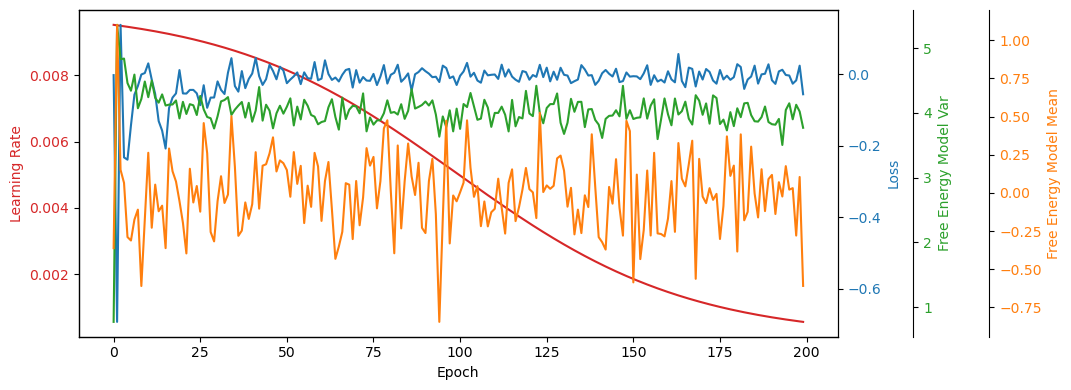

In [7]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
free_model_var_vals = [metrics[e]['free_energy_var'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.00))
ax2.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax2.set_ylabel("Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(epochs, free_model_var_vals, label="Free Energy Model Var", color="tab:green")
ax3.set_ylabel("Free Energy Model Var", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.plot(epochs, free_model_mean_vals, label="Free Energy Model Mean", color="tab:orange")
ax4.set_ylabel("Free Energy Model Mean", color="tab:orange")
ax4.tick_params(axis="y", labelcolor="tab:orange")

plt.tight_layout()
plt.show()

In [8]:
h_eval_values = [0.8, 1.0, 1.2]
eval_samples = 20_000
eval_steps = 200
T_eval = 1.0

l_axis_ref = list(range(1, CHAIN_LENGTH // 2 + 1))

rbm_data = {}
rng_eval = torch.Generator(device=next(model.parameters()).device).manual_seed(1234)

print("=== RENYI ENTROPY RECONSTRUCTION ===")

for h_val in h_eval_values:
    print(f"Processing h = {h_val}...")

    # 1. Generate
    cond_gen = torch.tensor([[h_val]], device=next(model.parameters()).device).expand(eval_samples, -1)
    T_schedule = torch.full((eval_steps,), T_eval, device=cond_gen.device)

    with torch.no_grad():
        samples = model.generate(cond_gen, T_schedule, rng_eval)

    # 2. Score
    cond_score = torch.tensor([[h_val]], device=next(model.parameters()).device)
    scorer = lambda v: model.log_score(v, cond_score)

    # 3. Compute
    curve = []
    for l in l_axis_ref:
        s2 = compute_renyi_entropy(samples, l, scorer)
        curve.append(s2)

    rbm_data[h_val] = curve
    print(f" -> {[round(x, 4) for x in curve]}")

=== RENYI ENTROPY RECONSTRUCTION ===
Processing h = 0.8...
 -> [0.5044, 0.6271, 0.6665, 0.6854, 0.6965, 0.6947, 0.7009, 0.6973]
Processing h = 1.0...
 -> [0.3611, 0.4534, 0.4967, 0.5242, 0.5669, 0.5662, 0.5661, 0.5899]
Processing h = 1.2...
 -> [0.2067, 0.2489, 0.2798, 0.2769, 0.2905, 0.2897, 0.2978, 0.307]


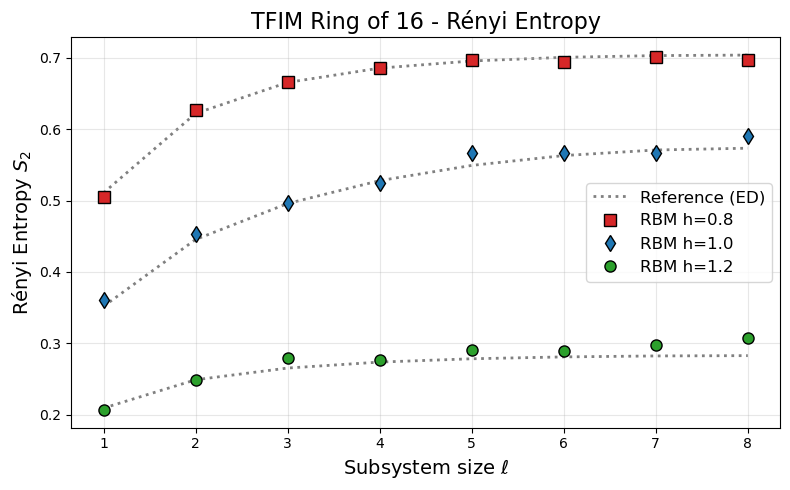

In [9]:
chain_length = CHAIN_LENGTH
ref_file = Path(f"tfim_{chain_length}_entropy_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

l_axis_ref = []
l_cols = []
if ref_df is not None:
    l_cols = sorted([c for c in ref_df.columns if c.startswith("l")], key=lambda s: int(s[1:]))
    l_axis_ref = [int(c[1:]) for c in l_cols]
else:
    l_axis_ref = list(range(1, chain_length // 2 + 1))

styles = {
    0.8: {'color': 'tab:red',   'fmt': 's', 'label': 'h=0.8'},
    1.0: {'color': 'tab:blue',  'fmt': 'd', 'label': 'h=1.0'},
    1.2: {'color': 'tab:green', 'fmt': 'o', 'label': 'h=1.2'}
}

#### PLOTTING ####

plt.figure(figsize=(8, 5))

ref_label_added = False

sorted_h = sorted(rbm_data.keys())

for h in sorted_h:
    st = styles.get(h, {'color': 'black', 'fmt': 'x', 'label': f'h={h}'})

    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-8)
        if mask.any():
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values
            lbl = "Reference (ED)" if not ref_label_added else "_nolegend_"
            plt.plot(l_axis_ref, y_ref, ':', color='gray', linewidth=2.0,
                     label=lbl, zorder=1)
            ref_label_added = True

    s2_vals = rbm_data[h]
    l_rbm = range(1, len(s2_vals) + 1)
    plt.plot(l_rbm, s2_vals, marker=st['fmt'], linestyle='None', color=st['color'], markersize=8,
             markeredgecolor='k', label=f"RBM {st['label']}", zorder=2)


plt.xlabel("Subsystem size $\\ell$", fontsize=14)
plt.ylabel(r"Rényi Entropy $S_2$", fontsize=14)
plt.title(f"TFIM Ring of {chain_length} - Rényi Entropy", fontsize=16)

plt.legend(frameon=True, fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()